In [8]:
import meep as mp 
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 16})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

In [9]:
a = 405e-9 # nm
t = 180e-9 / a

c = 3e8

fcen = 350e12 * a / c                                     # 340 THz(inside band-gap), since a = 405 nm, and c = 3e8: f=freq*a/c
df = 50e12 * 2 * a / c

In [10]:
print('Frequency of transition in MEEP units: ',fcen)

Frequency of transition in MEEP units:  0.4725


In [11]:
print(df)

0.135


In [12]:
resolution = 4                                               # 12 pixels per unit a.

length = 30
lengthz = 5

N = 27

cell = mp.Vector3(length, length, lengthz)                      # 3D case

dpml = 1

pml_layers = [mp.PML(dpml)]

geometry = [mp.Block(center=mp.Vector3(0,0,0), 
            size=mp.Vector3(length-2*dpml,length-2*dpml,t), 
            material=mp.Medium(index = 2))]                    # Block of SiN extending up to PML region 

# A hexagonal prism defined by six vertices centered on the origin
# of material crystalline silicon (from the materials library)

multiplier = (1-t)*0.5

multiplier*1/np.sqrt(3)

vertices = [mp.Vector3(0,multiplier*2/np.sqrt(3)),
            mp.Vector3(multiplier*1,multiplier*1/np.sqrt(3)),
            mp.Vector3(multiplier*1,-multiplier*1/np.sqrt(3)),
            mp.Vector3(0,multiplier*-2/np.sqrt(3)),
            mp.Vector3(-multiplier*1,-multiplier*1/np.sqrt(3)),
            mp.Vector3(-multiplier*1,multiplier*1/np.sqrt(3))]

from hexalattice.hexalattice import *
hex_centers, _ = create_hex_grid(nx=N, ny=N, crop_circ=N//2)

for center in hex_centers: 
    center_final = mp.Vector3(center[0], center[1])
    geometry.append(mp.Prism(vertices,
                                     height=t,
                                     center=center_final,
                                     material=mp.Medium(index = 1))) #add the hexagons in the lattice

                 
src = [mp.Source(src=mp.GaussianSource(fcen, fwidth=0.5, is_integrated = True),
                     center=mp.Vector3(x=0.0, y=0.0, z=0.0),
                     component=mp.Ex, 
                     amplitude=1.0,
                     ),
      ]


symmetries = [mp.Mirror(mp.Z)]

sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=src,
                    symmetries = symmetries,
                    resolution=resolution,
                    force_complex_fields=True
                   )

nfreq = 150

In [13]:
dft_fields = sim.add_dft_fields([mp.Ex], fcen, df, nfreq, center=mp.Vector3(0.0,0.0,0.0), size=mp.Vector3(10/resolution,10/resolution,10/resolution))

-----------
Initializing structure...
Halving computational cell along direction z
time for choose_chunkdivision = 0.00148678 s
Working in 3D dimensions.
Computational cell is 30 x 30 x 5 with resolution 4
     block, center = (0,0,0)
          size (28,28,0.444444)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4,4,4)
     prism, center = (-6.5,-11.2583,0)
          height 0.444444, axis (0,0,1), sidewall angle: 0 radians, 6 vertices:
          (-6.5,-10.9376,-0.222222)
          (-6.22222,-11.098,-0.222222)
          (-6.22222,-11.4187,-0.222222)
          (-6.5,-11.5791,-0.222222)
          (-6.77778,-11.4187,-0.222222)
          (-6.77778,-11.098,-0.222222)
          dielectric constant epsilon diagonal = (1,1,1)
     prism, center = (-5.5,-11.2583,0)
          height 0.444444, axis (0,0,1), sidewall angle: 0 radians, 6 vertices:
          (-5.5,-10.9376,-0.222222)
          (-5.22222,-11.098,-0.222222)
          (-5.22222,-11.4187,-0.222

<AxesSubplot:xlabel='X', ylabel='Y'>

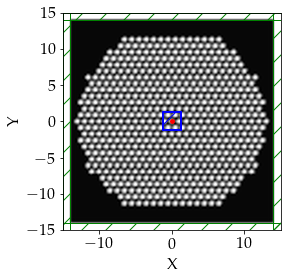

In [14]:
sim.plot2D(output_plane=mp.Volume(center=mp.Vector3(0,0,0),size=mp.Vector3(length,length,0)))

<AxesSubplot:xlabel='X', ylabel='Z'>

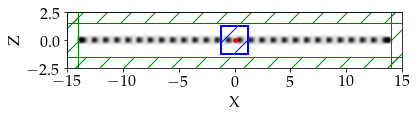

In [15]:
sim.plot2D(output_plane=mp.Volume(center=mp.Vector3(0,0,0),size=mp.Vector3(length,0,lengthz)))

In [16]:
sim.run(until_after_sources=100)

Meep progress: 14.625/120.0 = 12.2% done in 4.0s, 28.9s to go
on time step 117 (time=14.625), 0.034253 s/step
Meep progress: 36.625/120.0 = 30.5% done in 8.0s, 18.3s to go
on time step 293 (time=36.625), 0.0228033 s/step
Meep progress: 58.625/120.0 = 48.9% done in 12.0s, 12.6s to go
on time step 469 (time=58.625), 0.0227677 s/step
Meep progress: 80.75/120.0 = 67.3% done in 16.0s, 7.8s to go
on time step 646 (time=80.75), 0.0226071 s/step
Meep progress: 103.0/120.0 = 85.8% done in 20.0s, 3.3s to go
on time step 824 (time=103), 0.0225466 s/step
run 0 finished at t = 120.0 (960 timesteps)


In [17]:
Ex = []
for i in range(nfreq):   
    Ex.append(sim.get_dft_array(dft_fields,mp.Ex,i))

In [18]:
Ex = np.array(Ex)

In [19]:
np.shape(Ex)

(150, 12, 12, 12)